In [4]:
#!pip install unidecode
#!pip install matplotlib
#!pip install seaborn
#!pip install nltk
#!pip install scikit-learn

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import unidecode
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /home/hygo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hygo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hygo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/hygo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [15]:
df = pd.read_csv("filmes.csv")


In [16]:
# Contar a frequência de cada gênero
genre_counts = df['genres'].value_counts()

# Filtrar gêneros com mais de 1 instância
valid_genres = genre_counts[genre_counts > 1].index
df_filtered = df[df['genres'].isin(valid_genres)]

# # Realizar amostragem estratificada novamente
# df_sample, _ = train_test_split(df_filtered, test_size=0.8, stratify=df_filtered['genres'], random_state=42)
#
# print(f"Tamanho do sample: {len(df_sample)}")
#
# df = df_sample

In [17]:
def lower_clean(text):
 text = text.lower()
 text = re.sub(r'[^a-z\s]', '', text) # Apenas letras e espaços
 return text

def unidecode_text(text):
 return unidecode.unidecode(text)

def tokenize(text: str) -> list:
 return word_tokenize(text)

def remove_stopwords(tokens: list) -> list:
 stop_words = set(stopwords.words('english'))
 return [word for word in tokens if word not in stop_words]

def lemmatize(tokens: list) -> list:
 lemmatizer = WordNetLemmatizer()
 return [lemmatizer.lemmatize(word) for word in tokens]

def stemming(tokens: list) -> list:
 stemmer = PorterStemmer()
 return [stemmer.stem(word) for word in tokens]


In [19]:
def preprocess_pipeline(text: str) -> str:
    cleaned_text = lower_clean(text)
    unidecoded_text = unidecode_text(cleaned_text)
    tokens = tokenize(unidecoded_text)
    tokens_no_stopwords = remove_stopwords(tokens)
    lemmatized_tokens = lemmatize(tokens_no_stopwords) # testar stemming(tokens_no_stopwords)
    return ' '.join(lemmatized_tokens)


In [21]:
df['sinopse'] = df['sinopse'].fillna('')

df['processed_sinopse'] = df['sinopse'].apply(preprocess_pipeline)

# Visualizar as 5 primeiras linhas
df[['sinopse', 'processed_sinopse']].head()

,sinopse,processed_sinopse
0,When two kids find and play a magical board ga...,two kid find play magical board game release m...
1,John and Max resolve to save their beloved bai...,john max resolve save beloved bait shop turnin...
2,"Based on Terry McMillan's novel, this film fol...",based terry mcmillans novel film follows four ...
3,George Banks must deal not only with his daugh...,george bank must deal daughter pregnancy also ...
4,A group of high-end professional thieves start...,group highend professional thief start feel he...


In [25]:
# Criar o vetorizador TF-IDF

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df['processed_sinopse'])


# Converter a matriz TF-IDF para um DataFrame para visualização
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Visualizar as primeiras linhas
tfidf_df.head()

,aa,aa milne,aadhi,aaron,aaron young,aarti,aback,abandon,abandon family,abandon life,...,zoo meet,zookeeper,zoologist,zoom,zootechnician,zorro,zoya,zu,zurich,zweig
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Padronizar os dados antes de aplicar PCA
scaler = StandardScaler()
tfidf_scaled = scaler.fit_transform(tfidf_matrix.toarray()) # Converter para denso antes do PCA

# Definir número de componentes principais
n_components = 50 # Ajuste conforme necessário

# Aplicar PCA na matriz TF-IDF padronizada
pca = PCA(n_components=n_components, random_state=42)
tfidf_pca = pca.fit_transform(tfidf_scaled)

# Exibir dimensões antes e depois do PCA
print(f"Dimensão original da matriz TF-IDF: {tfidf_matrix.shape}")
print(f"Dimensão reduzida da matriz após PCA: {tfidf_pca.shape}")

Dimensão original da matriz TF-IDF: (30358, 68061)
Dimensão reduzida da matriz após PCA: (30358, 50)


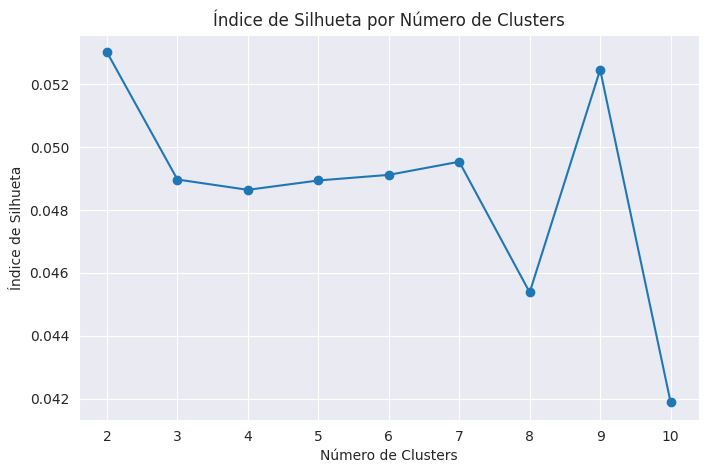

In [27]:
from sklearn.metrics import silhouette_score

# Testar diferentes números de clusters
silhouette_scores = []
for k in range(2, 11):  # Testando de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(tfidf_pca)
    score = silhouette_score(tfidf_pca, clusters)
    silhouette_scores.append(score)

# Plotar os índices de silhueta
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Índice de Silhueta por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Índice de Silhueta")
plt.show()

In [28]:
# Escolha o número de clusters ideal
optimal_k = 8  # ou 4, com base no gráfico

# Reaplicar o K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(tfidf_pca)
df['cluster'] = clusters


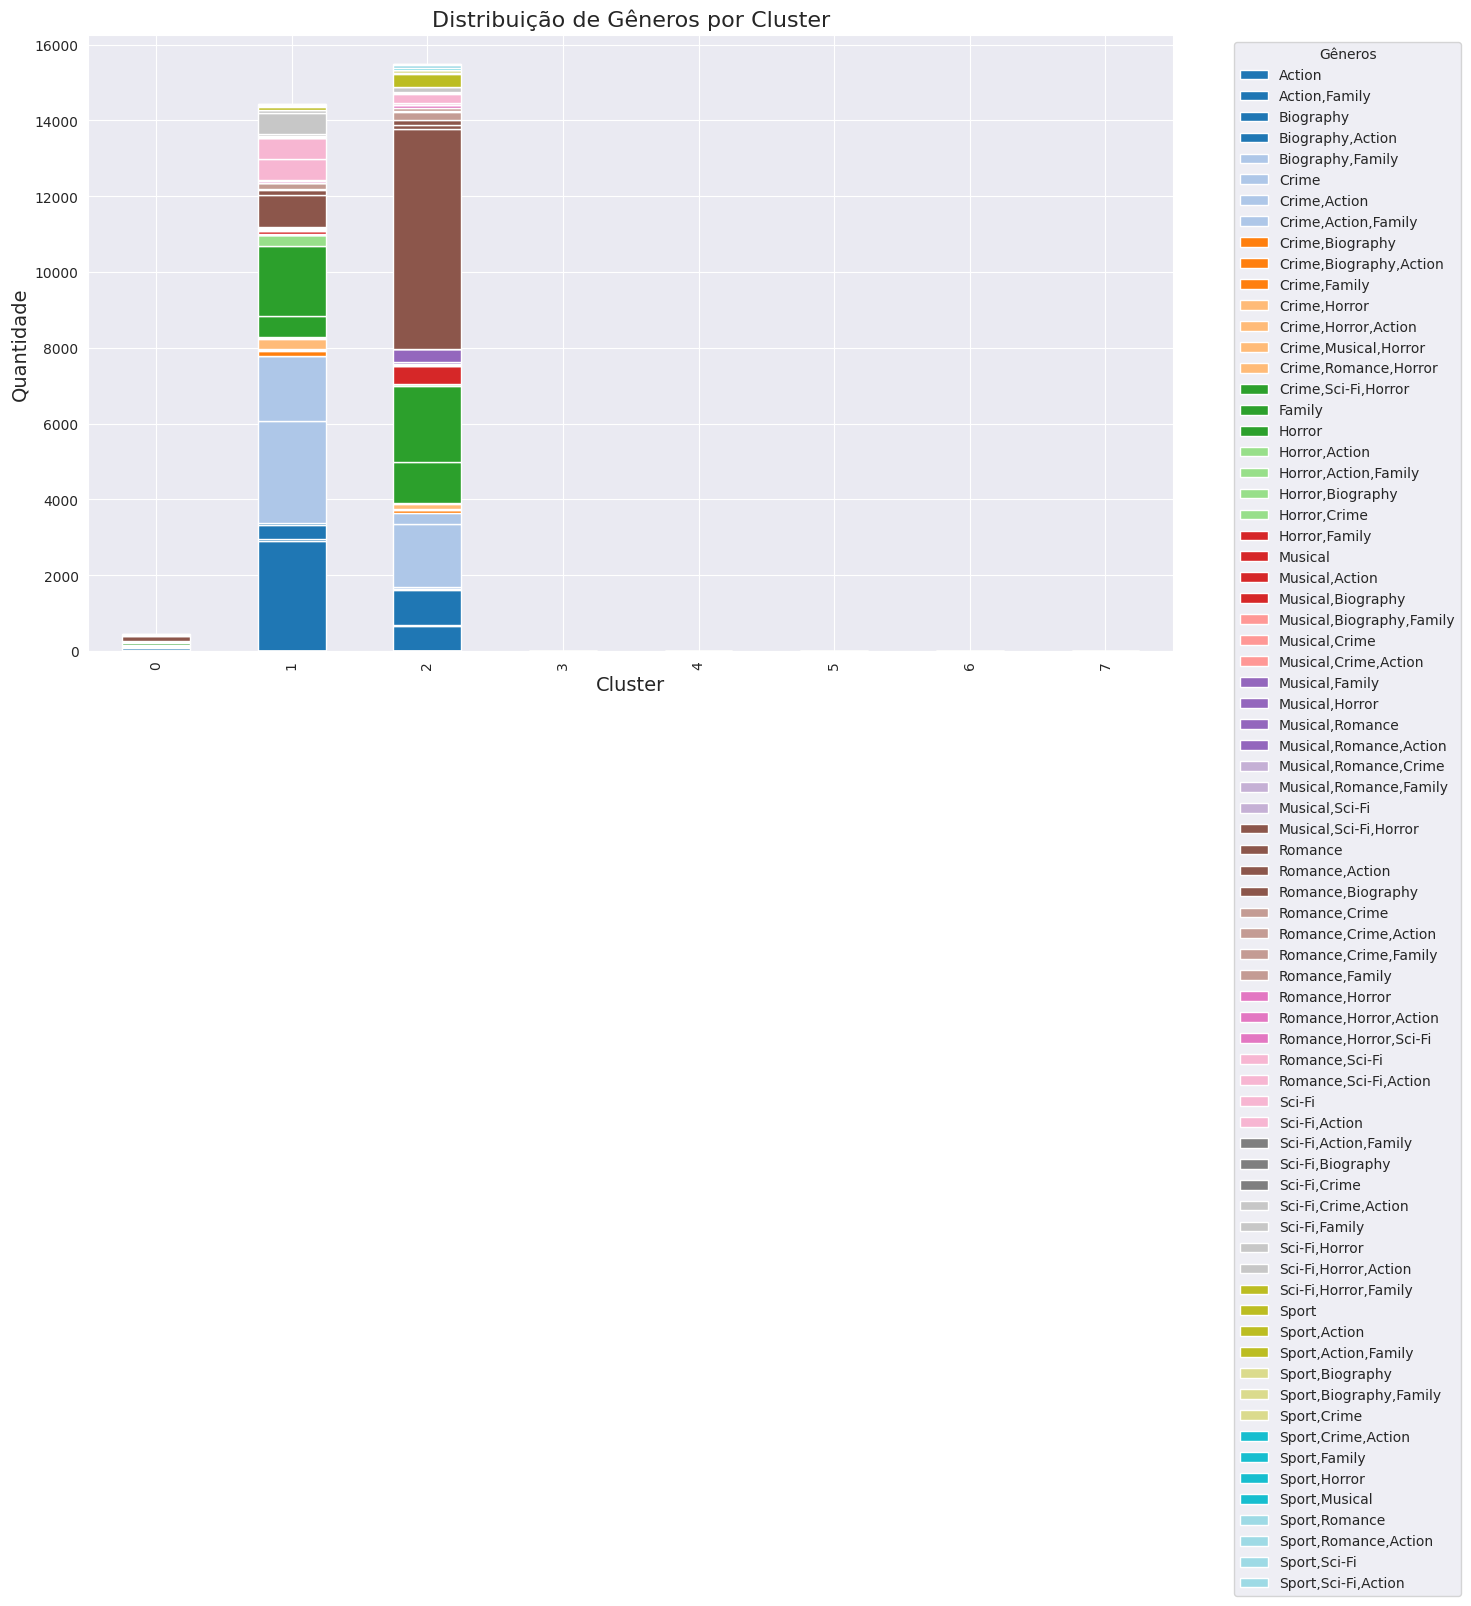

In [29]:
# Contar gêneros por cluster
genre_cluster = df.groupby(['cluster', 'genres']).size().reset_index(name='count')

# Pivotar para gráfico de barras empilhadas
pivot = genre_cluster.pivot(index='cluster', columns='genres', values='count').fillna(0)

# Criar o gráfico de barras empilhadas
pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

# Melhorar layout
plt.title('Distribuição de Gêneros por Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Quantidade', fontsize=14)
plt.legend(title='Gêneros', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [36]:
# Validação do agrupamento
silhouette = silhouette_score(X_reduced, clusters)
print(f"Índice de Silhueta: {silhouette:.2f}")

NameError: name 'X_reduced' is not defined